#### Imports

In [1]:
from typing import Dict, List, Tuple, Optional
from collections import namedtuple

In [2]:
from functional import seq, pseq
from functional.streams import Sequence
from IPython.core.display import HTML

def display_seq(sequence:Sequence,rows:int)-> None:
        sequence._repr_html_= lambda :sequence.tabulate(rows,tablefmt='html')
        display(sequence)
        sequence._repr_html_= lambda :sequence.tabulate(10,tablefmt='html')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import functools
def compose(*functions):
    def compose2(f, g):
        return lambda x: f(g(x))
    return functools.reduce(compose2, functions, lambda x: x)

#  Csv Processing

In [6]:
import util
base_dir = util.get_envs()['base_dir']
neo_dir = "/home/owner/blob/data/data_mining/dblp/csv_for_neo/"

In [8]:
infomap_dir =  base_dir + "infomap/"

### Nodes

In [9]:
publications = pd.read_csv(base_dir + "publications.csv")
print(publications.columns)
publications.head(n=2)

Index(['key', 'type', 'title', 'year'], dtype='object')


,key,type,title,year
0,books/acm/0082477,book,The no-nonsense guide to computing careers.,1992
1,books/acm/Kim95,book,Modern Database Systems: The Object Model Inte...,1995


In [10]:
persons = pd.read_csv(base_dir + "persons.csv").drop_duplicates(subset="key").dropna()
print(persons.columns)
persons.head()


Index(['key', 'name'], dtype='object')


,key,name
0,johann sebastian rudolph_pers,Johann Sebastian Rudolph
1,anau mesui_pers,Anau Mesui
2,maseka lesaoana_pers,Maseka Lesaoana
3,niran adetoro_pers,Niran Adetoro
4,yinka oyerinde_pers,Yinka Oyerinde


In [11]:
len(persons[persons.duplicated()])

0

In [9]:
venues = pd.read_csv(base_dir + "venues.csv").drop_duplicates(subset="key")
venues = venues.where(venues.name != venues.type).dropna()
print(venues.columns)
venues.head()

Index(['key', 'name', 'type'], dtype='object')


,key,name,type
0,acm_venue,ACM,publisher
1,modern database systems_venue,Modern Database Systems,book
2,computational complexity theory_venue,Computational Complexity Theory,book
3,ams chelsea publishing_venue,AMS Chelsea Publishing,publisher
4,academic press_venue,Academic Press,publisher


### Edges

In [9]:
authored = pd.read_csv(base_dir + "authored.csv")
print(authored.columns)
authored.head()

Index(['author_name', 'publication_key'], dtype='object')


,author_name,publication_key
0,marc rettig_pers,books/acm/0082477
1,won kim 0001_pers,books/acm/Kim95
2,jurgen annevelink_pers,books/acm/kim95/AnnevelinkACFHK95
3,rafiul ahad_pers,books/acm/kim95/AnnevelinkACFHK95
4,amelia carlson_pers,books/acm/kim95/AnnevelinkACFHK95


In [10]:
cited = pd.read_csv(base_dir + "cited.csv")
print(cited.columns)
cited = cited.where(cited["cited"] != "...").drop_duplicates().dropna()

Index(['citing', 'cited'], dtype='object')


In [15]:
in_venue = pd.read_csv(base_dir + "in_venue.csv")
print(in_venue.columns)
in_venue.head(n=3)

Index(['publication_key', 'venue_name'], dtype='object')


,publication_key,venue_name
0,books/acm/0082477,acm_venue
1,books/acm/Kim95,modern database systems_venue
2,books/acm/kim95/AnnevelinkACFHK95,modern database systems_venue


## saving cleaned csv for neo4j import

In [27]:
import os
os.mkdir(neo_dir)

In [28]:
publications.to_csv(neo_dir+ 'publications.csv' ,header=False,index=False)
persons.to_csv(neo_dir+ 'persons.csv' ,header=False,index=False)
venues.to_csv(neo_dir+ 'venues.csv' ,header=False,index=False)
authored.to_csv(neo_dir+ 'authored.csv' ,header=False,index=False)
cited.to_csv(neo_dir+ 'cited.csv' ,header=False,index=False)
in_venue.to_csv(neo_dir+ 'in_venue.csv' ,header=False,index=False)

not sure if cite count is ok

# Bibliometric indicators

## H-index

In [11]:
c_counts = cited.copy()
c_counts["cites_count"] = 1
c_counts = c_counts.drop("citing",axis=1)
c_counts = c_counts.groupby("cited").sum().reset_index()
c_counts = c_counts.dropna()

In [12]:
authors_with_counts = pd.merge(authored, c_counts, how='outer', left_on=['publication_key'], right_on=['cited']).dropna().sort_values("cites_count",ascending=False)
authors_with_counts = authors_with_counts.drop("cited",axis=1)
len(authors_with_counts)

45374

In [18]:
def h_index_pandas(author_name:str) -> int :
    kim = authors_with_counts.where(authors_with_counts["author_name"] == author_name).dropna()
    kim["seq_nr"] = range(1,len(kim)+1)
    kim = kim.where(kim.cites_count >= kim.seq_nr ).dropna().tail(1)

    kim['h_score'] = kim[['seq_nr','cites_count']].min(axis=1)
    return kim['h_score'].sum()

In [13]:
author_with_counts_seq = seq(authors_with_counts)

In [14]:
h_index = author_with_counts_seq.group_by(lambda x: x[0])\
.map(lambda x:
     seq(x[1]).zip_with_index(start=1) #Entry: ([Author,Paper,Citations],row_nr)
     .map(lambda zipped: (zipped[0][0],zipped[0][-1],zipped[1]) ) #Entry: (Author,Citations,row_nr)
     .take_while(lambda x : x[1]>= x[2]).last()
    ).map(lambda row : (row[0], min(row[1],row[2]))).order_by(lambda x: -x[1])

In [16]:
person_key_name_dict = seq(persons[['key','name']]).to_dict()

In [23]:
display_seq(h_index.map(lambda x: (person_key_name_dict[x[0]],x[1])),rows=30)

Jeffrey D. Ullman,28
Michael Stonebraker,27
David J. DeWitt,24
Philip A. Bernstein,22
Won Kim 0001,21
Yehoshua Sagiv,20
Rakesh Agrawal 0001,20
Catriel Beeri,20
Michael J. Carey 0001,20
Umeshwar Dayal,20
Jim Gray 0001,19


In [53]:
h_index_pandas(h_index.head()[0])

28.0

### Draw H-index

In [32]:
def plot_x_index_histogram(index,letter):
    n, bins, patches = plt.hist(index.map(lambda x: x[1]).to_list(),bins=20,  facecolor='pink', log=True)
    plt.ylabel('Author count')
    plt.xlabel(letter + '-index')
    plt.show()

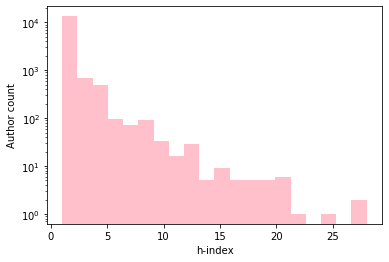

In [33]:
plot_x_index_histogram(h_index,'h')

In [56]:
def plot_x_index_points(index,letter):
    _numbers = index.group_by(lambda x: x[1]).map(lambda x:(x[0],len(x[1])))
    fig = plt.figure()
    ax = fig.add_subplot(2, 1, 1)
    ax.scatter(_numbers.map(lambda x: x[0]).to_list(),_numbers.map(lambda x:x[1]).to_list())
    plt.ylabel('Author count')
    plt.xlabel(letter + '-index')
    ax.set_yscale('log')

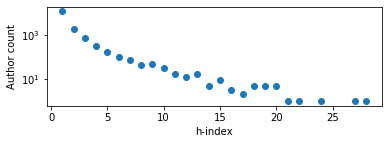

In [57]:
plot_x_index_points(h_index,'h')

## G-index
https://libguides.aalto.fi/c.php?g=647846&p=4542760

In [34]:
def cumulative_sum(s:Sequence) -> Sequence:  #Seq[int] -> Seq[int]
    return s.fold_left([0],lambda acc,e : acc + [acc[-1] + e] ).drop(1)
    

def add_cumulative_sum(entries:Sequence) -> Sequence: #Seq[(A,Citations,R)] -> Seq[(A,Citations,CumSum,R)]
    cum_sum = cumulative_sum(entries.map(lambda x: x[1]))
    return entries.zip(cum_sum).map(lambda x: (x[0][0],x[0][1],x[1],x[0][2]))
    

In [35]:
g_index = author_with_counts_seq.group_by(lambda x: x[0])\
    .map(lambda x:
         add_cumulative_sum(
             seq(x[1]).zip_with_index(start=1)
             .map(lambda zipped: (zipped[0][0], zipped[0][-1], zipped[1])) # Entry: (Author,Citations,row_nr)
         )  # Entry: (Author,Citations,CumSum,row_nr)
        ).map(lambda x: x.take_while(lambda x: x[2] >= (x[3]*x[3])).last())\
.map(lambda row: (row[0], min(row[2], row[3])))\
.order_by(lambda x: -x[1])

In [38]:
display_seq(g_index.map(lambda x: (person_key_name_dict[x[0]],x[1])),rows=30)

Jeffrey D. Ullman,56
Michael Stonebraker,46
David J. DeWitt,44
Jim Gray 0001,43
Philip A. Bernstein,42
David Maier 0001,39
Won Kim 0001,36
Nathan Goodman,35
Serge Abiteboul,35
Yehoshua Sagiv,34
Catriel Beeri,34


### Draw G-index

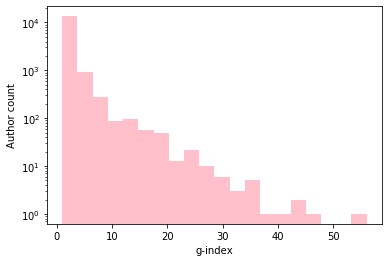

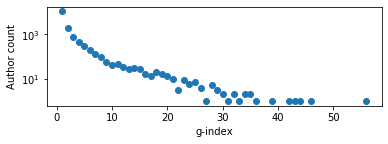

In [61]:
plot_x_index_histogram(g_index,'g')
plot_x_index_points(g_index,'g')

## Journal impact factor TODO

# Adjusting graph in Neo4j

In [38]:
from py2neo import Graph,Node
graph = Graph("bolt://127.0.0.1:7687",auth=("neo4j", "admin"))

### Create indices

In [17]:
# graph.run("create index on :publication(key)")
# graph.run("create index on :person(key)")
# graph.run("create index on :venue(key)")

## Co-authorship graph preparation

### Creating

In [11]:
authored.head()

,author_name,publication_key
0,marc rettig_pers,books/acm/0082477
1,won kim 0001_pers,books/acm/Kim95
2,jurgen annevelink_pers,books/acm/kim95/AnnevelinkACFHK95
3,rafiul ahad_pers,books/acm/kim95/AnnevelinkACFHK95
4,amelia carlson_pers,books/acm/kim95/AnnevelinkACFHK95


In [7]:
def to_coauthorship_tuples(arr):
    return ((arr[i],arr[j]) for i in range(0,arr.size() -1) for j in range(i+1, arr.size()))

In [8]:
grouped = seq(authored).group_by(lambda x :x[1])\
.filter(lambda x: len(x[1]) > 1)

In [20]:
coauthorships = grouped.flat_map(lambda x: to_coauthorship_tuples(seq(x[1]).map(lambda author_book:author_book[0])))\
.count_by_value() \
.map(lambda x: (x[0][0],x[0][1],x[1])).to_pandas(columns= ['a_key','b_key','count'])

In [11]:
coauthorships.head()

,a_key,b_key,count
0,jurgen annevelink_pers,rafiul ahad_pers,1
1,jurgen annevelink_pers,amelia carlson_pers,1
2,jurgen annevelink_pers,daniel h. fishman_pers,1
3,jurgen annevelink_pers,michael l. heytens_pers,1
4,jurgen annevelink_pers,william kent_pers,3


In [23]:
co = seq(coauthorships).map(lambda x: (*tuple(sorted((x[0],x[1]))),x[2]))\
    .to_pandas(columns= ['a_key','b_key','count'])\
    .groupby(['a_key','b_key'],as_index=False,axis=0).sum()

In [24]:
len(co)

12284722

In [25]:
co.to_csv(base_dir + "/coauthorships.csv", index=False,header=False)

### Inserting

In [8]:
coauthorships = pd.read_csv(base_dir + "/coauthorships.csv",header=None,names= ['a_key','b_key','count'])

In [9]:
len(coauthorships)

12284722

In [12]:
coauthorships =  coauthorships.where(coauthorships.a_key != coauthorships.b_key).dropna()

In [13]:
len(coauthorships)

12284648

In [36]:
chunk_nb = int(len(coauthorships) /10000)
chunk_nb

1228

In [40]:
import tqdm
for i,chunk in tqdm.tqdm(enumerate(np.array_split(coauthorships,chunk_nb)),total=chunk_nb):
    entries = seq(chunk).map(lambda x : {'a':x[0],'b':x[1],'cnt': x[2]}).to_list()
    tx= graph.begin()
    tx.run("""
unwind {entries} as e
match  (a:person{key:e.a}) with a, e
match (b:person{key:e.b}) with a,b,e
merge(a)-[:COAUTHORS_WITH{count: e.cnt}]->(b)
return count(*)
""",entries=entries)
    tx.commit()

100%|██████████| 1228/1228 [17:55<00:00,  1.34it/s]


### Creating infomap

In [14]:
import igraph as ig
iGraph = ig.Graph.TupleList(seq(coauthorships).to_list(),weights=True,vertex_name_attr='id')

In [15]:
iGraph.write_pajek(base_dir + "coauthorships.net")

Running infomap:
`./Infomap  ~/blob/data/data_mining/dblp/csv/coauthorships.net .`

### Inserting infomap results

In [10]:
base_dir

'/home/owner/blob/data/data_mining/dblp/csv/'

`tail -n +3 < infomap.tree | sd '(?P<path>(\d+:)+\d+)\s.*?"(?P<id>.*?)".*' ' $path,$id' > infomap_cleaned.csv`

In [9]:
infomap = pd.read_csv(base_dir + "/infomap/infomap_cleaned.csv",header=None,names=['path','key'])

In [10]:
infomap['path_len'] = infomap.path.apply(lambda x : len(x.split(":")))

In [11]:
infomap.head()

,path,key,path_len
0,1:1:1,qiang wang_pers,3
1,1:1:2,philip h. s. torr_pers,3
2,1:1:3,jiri matas_pers,3
3,1:1:4,haibin ling_pers,3
4,1:1:5,zheng zhang_pers,3


In [8]:
infomap.path_len.min(),infomap.path_len.max()

(2, 5)

#### Trimming paths

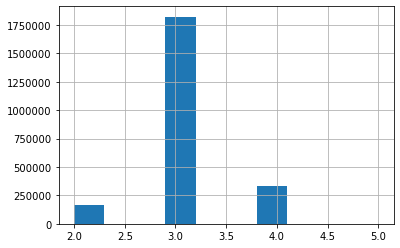

In [10]:
infomap.path_len.hist(bins=10)

In [12]:
infomap.head(n=1)

,path,key,path_len
0,1:1:1,qiang wang_pers,3


In [13]:
def path3(s:str) -> str:
    s = s.split(":")
    return "{}:{}:{}".format(s[0],s[1], s[2] if len(s) >2 else 0)

def path2(s:str) -> str:
    s = s.split(":")
    return "{}:{}".format(s[0],s[1])

In [14]:
infomap['path2'] = infomap.path.apply(path2)
infomap['path3'] = infomap.path.apply(path3)

In [15]:
infomap['major'] = infomap.path.apply(lambda p: int(p.split(':')[0]))
infomap['minor'] = infomap.path.apply(lambda p: int(p.split(':')[1]))

In [16]:
print(infomap.minor.min(),infomap.major.max())
print(infomap.minor.min(),infomap.minor.max())

1 57627
1 10910


In [17]:
infomap.head()

,path,key,path_len,path2,path3,major,minor
0,1:1:1,qiang wang_pers,3,1:1,1:1:1,1,1
1,1:1:2,philip h. s. torr_pers,3,1:1,1:1:2,1,1
2,1:1:3,jiri matas_pers,3,1:1,1:1:3,1,1
3,1:1:4,haibin ling_pers,3,1:1,1:1:4,1,1
4,1:1:5,zheng zhang_pers,3,1:1,1:1:5,1,1


In [20]:
infomap.to_csv(infomap_dir  + 'author_community.csv',index=False)

In [71]:
infomap_counts = infomap[['path2','key']].groupby('path2',as_index = False).count()
infomap_counts = infomap_counts.where(infomap_counts.key >1).dropna()

In [72]:
infomap_counts.quantile([0.5,0.8,0.9,0.999,1])

,key
0.500,12.000
0.800,33.000
0.900,53.000
0.999,296.766
1.000,792.000


In [74]:
infomap_counts.head(n=1)

,path2,key
476,100:1,151.0


In [75]:
interesting_infomaps = seq(infomap_counts.path2).to_set()

In [76]:
infomap_to_insert = infomap.where(infomap.path2.isin(interesting_infomaps)).dropna()[['path2','key']]

In [81]:
print(len(infomap_to_insert)/len(infomap))
infomap_to_insert.head()

0.9300710969646352


,path2,key
0,1:1,qiang wang_pers
1,1:1,philip h. s. torr_pers
2,1:1,jiri matas_pers
3,1:1,haibin ling_pers
4,1:1,zheng zhang_pers


In [84]:
chunk_nb = int(len(infomap_to_insert) /10000)
chunk_nb

215

In [85]:
import tqdm
for i, chunk in tqdm.tqdm(enumerate(np.array_split(infomap_to_insert,chunk_nb)),total=chunk_nb):
    entries = seq(chunk).map(lambda x : {'label':x[0],'person':x[1]}).to_list()
    tx= graph.begin()
    tx.run("""
unwind {entries} as e
MATCH (a:person{key:e.person})
set a.infomap = e.label
""",entries=entries)
    tx.commit()


100%|██████████| 215/215 [01:14<00:00,  2.37it/s]


In [8]:
infomap = pd.read_csv(base_dir + "/infomap_minor/author_community.csv",header=None)
infomap.columns = ['major','minor','key']

In [9]:
major_max = infomap.major.max()
minor_max = infomap.minor.max()
print(major_max)

57627


In [19]:
seq(infomap).filter(lambda x: not str(x[0]).isnumeric() )

1:36,1,1,hannu tenhunen_pers
1:36,1,2,pasi liljeberg_pers
1:36,1,3,juha plosila_pers
1:36,1,4,masoud daneshtalab_pers
1:36,1,5,amir-mohammad rahmani_pers
1:36,1,6,masoumeh ebrahimi_pers
1:36,1,7,amir m. rahmani_pers
1:36,1,8,tiberiu seceleanu_pers
1:36,1,9,tomi westerlund_pers
1:36,1,10,mohammad hashem haghbayan_pers


### Minor:

In [13]:
max_major = infomap.major.max()
infomap['label'] = infomap.major * max_major + infomap.minor
infomap = infomap.drop(['minor','major'],axis=1)
infomap.head()

TypeError: '>=' not supported between instances of 'str' and 'int'

In [60]:
chunk_nb = int(len(infomap)/ 2000 )
chunk_nb

1159

In [58]:
import tqdm
for i,chunk in tqdm.tqdm(enumerate(np.array_split(infomap,chunk_nb)),total=chunk_nb):
    entries = seq(chunk).map(lambda x : {'key':x[0],'label':x[1]}).to_list()
    tx= graph.begin()
    tx.run("""
unwind {entries} as e
MATCH (a:person{key:e.key})
set a.infomap_minor = e.label
return a
""",entries=entries)
    tx.commit()

100%|██████████| 1159/1159 [05:31<00:00,  3.50it/s]


### Major

In [63]:
infomap_major = infomap.drop('minor',axis=1)

In [64]:
infomap_major.head()

,major,key
0,1,qiang wang_pers
1,1,philip h. s. torr_pers
2,1,jiri matas_pers
3,1,haibin ling_pers
4,1,zheng zhang_pers


In [65]:
import tqdm
for i,chunk in tqdm.tqdm(enumerate(np.array_split(infomap_major,chunk_nb)),total=chunk_nb):
    entries = seq(chunk).map(lambda x : {'key':x[1],'label':x[0]}).to_list()
    tx= graph.begin()
    tx.run("""
unwind {entries} as e
MATCH (a:person{key:e.key})
set a.infomap_major = e.label
return a
""",entries=entries)
    tx.commit()

100%|██████████| 1159/1159 [05:59<00:00,  3.23it/s]
